## 1. How to load our images
### 1.1 MNIST-like load_data function
### 1.2 ImageDataGenerator
### 1.3 Dataframes

## 2. MNIST
## 3. Data augmentation
## 4. Pre-trained neural networks
## 5. RGB or grayscale
## 6. Conclusion

# Classifying album covers to genres

In the project we try to classify album covers to genres. The dataset has 5022 pictures, sepreated in five categories. The categories are Rock, Pop, Electronic, Jazz and HipHop. One of the challenges of classifying album covers is that there is no systematic which can be applied on covers. For example when we try to classify a picture as dog or cat, we humans can clearly se the difference. And the machine learning algorithm can try to detected shapes that are common for cats and dogs. But when humans look at an album cover, provided that they don't have any prior knowledge, it's hard classify an album cover. That first thought about the dataset leads to an early thesis that we probalby need an pre-trained neural network for solving this task appropriate. Because an pre-trained neural network brings in knowledge based on previeous trainings. 
Our approach is to start with traditional machine learning methods, like using an convolutional neural network inspired by the architecture used for classifying handwritten didgets from MNIST. 
After that we have an baseline for comparing with other methods and possible improvements. We will also take a look at multiclass classification, because some covers belong to more categories. And then we dive into pre trained neural networks like VGG16 and observe how they perform.

## some comfort functions

The cells below import all needed libraries, define all constants and also test if the systme is set up correctly. We don't need to duplicate the imports. We just import once before we run other cells with code.

In [17]:
#imports 
import sys
import os
import random
import matplotlib.pyplot as plt
# keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers


#tensorflow
import tensorflow.keras
import tensorflow as tf
# sci kit learm
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
from PIL import ImageChops


# Constants

IMG_SIZE=200
CATEGORIES = ['electronic', 'hiphop', 'jazz', 'pop', 'rock']
PERC_TRAIN = 0.8
PERC_VALIDATE = 0.1

In [11]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.2.0
Keras Version: 2.3.0-tf

Python 3.8.5 (default, Sep  5 2020, 10:50:12) 
[GCC 10.2.0]
Pandas 1.0.5
Scikit-Learn 0.23.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


# 1. How to load images

The dataset consists out of 5022 images seperated in the five categories Rock, Pop, Electronic, Jazz and HipHop.
For each category exists one folder with the associated images. We use three different approaches to load the data.
Our first approach is inspired by the MNIST dataset and we wrote our own `load_data` function. The second approach is the use of an `ImageDataGenerator` that needs a specific directory structure. And the last one is to use dataframes, which are csv files.

## 1.1 MNIST-like load_data function

In the MNIST example the data is loades via `load_data()` function, which returns two tuple with training and test data. This function is imitated by our `load_data()` function.
We define a function that goes through the specified path, converts the images to arrays and then appends them to the array $X$. Also it appends the class of the index to the array $y$. Then we use the Scikit-learn function train_test_split to split $X$ and $y$ into $X_{train}$, $X_{test}$, $y_{train}$, $y_{test}$ and return these variables.



In [3]:


# define some useful constants
DATA_PATH = './data/covers_original/'
CATEGORIES_SIZE = 5
TRAIN_PERC = 0.8
TEST_PERC = 0.2

# define a function that creates the dataset
def load_data():
    X = []
    y = []
    # training data
    for category in CATEGORIES:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img = load_img(os.path.join(path, img), target_size=(IMG_SIZE, IMG_SIZE))
                img_as_array = img_to_array(img)
                X.append(img_as_array)
                y.append(cn)
            except Exception as e:
                print(e)
    X = np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PERC)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

# test tuple
#print(X_train[0][0][0], "    ", y_train[0])
# reshape and normalize the data
X_train = X_train.reshape((4000, IMG_SIZE, IMG_SIZE, 3))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((1000, IMG_SIZE, IMG_SIZE, 3))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels (0-9)
y_train = np_utils.to_categorical(y_train, CATEGORIES_SIZE)
y_test = np_utils.to_categorical(y_test, CATEGORIES_SIZE)


## 1.2 ImageDataGenerator

ImageDataGenerator gives the opportunity to manipulate the images and enlarge our dataset. This plays an important role when the database is to small. The ImageDataGenerator can transform and rotate the images. That is called data augmentation. By applying data augmentation we hope to reduce or avoid overfitting because models tend to overfitting on small databases. That means the model descibes the
training and test data well but performs bad on new data. We will see later if this approache is as productive as expected.

The ImageDataGenerator needs a specific directory structure. At the root directory it needs three folder called train, test and validate. In every folder there exists an folder for each category. Then the images are split up in these folders. 80% of the data is going to train. 10% is going to test and another 10% to validate.
To use the ImageDataGenerator you just user the path to the specific directory.

* root
    * test
        * rock
        * pop
        * jazz
        * electronic
        * hiphoop
    * train
        * rock 
        * pop ...
    * validate
        * ...
        
        
For example the training data needs the path `./data/covers/training`. Then the generator will load and manipulate the data before it is processed by the model.

``` python
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_directory(
    './data/covers/training',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)


```

In [ ]:
DATA_DEST = './data/covers'
VALIDATION_PERC = 0.1
TEST_PERC = 0.1

categories = os.listdir(DATA_PATH)

# unfortunately this is too slow, removing the directory 
# using finder or explorer is way faster
# remove directory if it already exists (for convenience)
# if os.path.exists(DATA_DEST):
#     shutil.rmtree(DATA_DEST)
        
for category in categories:
    # set up some paths
    oldCategoryPath = os.path.join(DATA_PATH, category)
    newCategoryTrainingPath = os.path.join(os.path.join(DATA_DEST, 'training'), category)
    newCategoryValidationPath = os.path.join(os.path.join(DATA_DEST, 'validation'), category)
    newCategoryTestPath = os.path.join(os.path.join(DATA_DEST, 'test'), category)

    # get all files of each category
    files = os.listdir(os.path.join(DATA_PATH, category))
    
    # make a directory for each category
    os.makedirs(newCategoryTrainingPath)
    os.makedirs(newCategoryValidationPath)
    os.makedirs(newCategoryTestPath)
    
    # for each category, see how far we have to run for training and validation images.
    training_end = int((1-(VALIDATION_PERC + TEST_PERC)) * len(files))
    validation_end = training_end + int(VALIDATION_PERC * len(files))
    test_end = validation_end + int(TEST_PERC * len(files))
    
    # separate training and validation files
    training_files = files[:training_end]
    validation_files = files[training_end:validation_end]
    test_files = files[validation_end:test_end]
    print('Training files:', len(training_files))
    print('Validation files:', len(validation_files))
    print('Test files:', len(test_files))
    
    # copy training files to training path
    for idx, file in enumerate(training_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryTrainingPath, file)
            shutil.copy(oldFilePath, newFilePath)

    # copy validation files to validation path
    for idx, file in enumerate(validation_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryValidationPath, file)
            shutil.copy(oldFilePath, newFilePath)
    
    # copy validation files to test path
    for idx, file in enumerate(test_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryTestPath, file)
            shutil.copy(oldFilePath, newFilePath)

## 1.3 Dataframes

An Dataframe is a csv file that can be read by other processing steps and is used to access the data and give information about the data. We have a function that generates the csv file. The file has the rows `src` and `categories` where src is the path of each file and categories is an array of categories the image belongs to.
When the dataframe is imported, then the ImageDataGenerator can use this file for the augmentation. We don't need to split the data in the directory structure for ImageDataGenerator.

### Example 

|#| src| categrories|
|---|---|---|
|1| electronic\electronic.1.jpeg|['electronic', 'pop'] |
|2|electronic\electronic.106.jpeg|['electronic']|
|10|electronic\electronic.107.jpeg|['electronic', 'pop', 'rock']|
|11|electronic\electronic.108.jpeg|['electronic', 'pop', 'rock']|
|12|electronic\electronic.109.jpeg|['electronic']|
|13|electronic\electronic.11.jpeg|['electronic', 'rock']|
|14|electronic\electronic.110.jpeg|['electronic', 'rock']|

In [10]:

# define some useful constants
DATA_PATH = './data/covers_original/'
CATEGORIES = ['electronic', 'hiphop', 'jazz', 'pop', 'rock']
CATEGORIES_SIZE = 5
TRAIN_PERC = 0.8
TEST_PERC = 0.2

def equal(im1, im2):
    return ImageChops.difference(im1, im2).getbbox() is None

def findImg(img, array):
    for i, el in enumerate(array):
        if (el==img).all():
            return i
    return None

def findDictInArray(img, array):
    return next((index for (index, d) in enumerate(array) if (d["as_array"] == img).all()), None)

# define a function that creates the dataset
def load_data():
    data = []
    dupes = 0
    # training data
    for category in CATEGORIES:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_path_rel = os.path.join(category, img)
                image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img_as_array = np.array(img_to_array(image))
                # check if we have seen that image before
                #idx = findImg(img_as_array, X)
                idx = findDictInArray(img_as_array, data)
                print(idx)
                # if we have seen it already, update only the labels
                if not idx is None:
                    dupes += 1 # just to see how many duplicates we have
                    # sometimes images are duplicate in their own categories too
                    if not category in data[idx]['categories']:
                        data[idx]['categories'].append(category)
                else:
                    data.append({ 'src': img_path_rel, 'as_array': img_as_array, 'categories': [category]})
            except Exception as e:
                print(e)
    print('Anzahl dupes: ', dupes)
    return pd.DataFrame(data, columns=['src', 'categories'])

df = load_data()
print(df)
df.to_csv('./data/df_test_abgabe.csv')
#data.append({ 'src': '../data/image01.jpeg', 'categories': ['rock', 'pop'] })
#df = pd.DataFrame(data, columns=['src', 'categories'])

#print(df)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
68
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

None
None
None
None
None
None
None
None
None
None
None
None
None
None
478
None
None
None
None
None
1494
None
None
None
None
None
None
16
16
385
None
None
None
None
None
None
1276
None
1444
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
133
None
None
None
None
None
None
720
280
None
None
None
None
None
None
711
None
None
None
None
None
None
None
None
None
None
None
None
None
None
848
None
None
None
None
None
None
None
1556
None
None
None
None
None
1458
None
None
None
None
None
1168
None
None
None
None
None
None
None
None
None
1122
None
None
None
760
None
None
285
None
None
None
None
None
None
1122
None
None
None
None
None
None
None
None
1503
None
None
None
None
1665
None
None
1500
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
1230
280
55
None
None
None
None
None
None
None
None
None
None
None
1618
None
385
None
None
None
None
None
None
None
None
806
None
None
1387
Non

None
655
2070
None
None
None
850
2070
None
1879
None
None
484
None
None
None
None
13
None
None
None
2569
2884
None
None
None
None
2852
880
837
None
647
None
None
None
355
949
96
2260
None
None
2724
113
396
39
None
945
None
None
None
None
None
None
None
None
1855
None
None
None
None
None
None
268
925
None
None
None
None
631
None
583
283
None
None
2071
None
2264
None
2170
None
2604
264
None
119
2048
None
842
934
None
None
2910
None
462
2961
1975
None
None
570
None
None
813
None
761
None
944
334
None
None
None
None
212
105
None
None
None
None
None
None
None
None
None
None
2037
3
615
294
None
920
None
None
830
None
None
None
None
None
709
None
None
None
None
None
None
None
None
None
719
2739
1966
412
None
287
454
2800
945
None
None
120
None
None
None
25
314
None
None
None
None
None
None
196
None
309
None
None
None
1202
None
83
2524
None
158
240
None
None
None
787
None
None
None
517
485
352
None
421
None
None
None
None
None
None
None
141
None
None
None
539
362
565
None
2835
None
None
None
N

# 2 MNIST adapted to covers

We adapted the Code for MNIST dataset. The last layer now has dense of 5 because we decide between 5 classes.


In [4]:
# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu')) # reduced 1024 to 64 because of OOM Exceptions
model.add(Dense(5, activation='softmax'))
model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                10240064  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

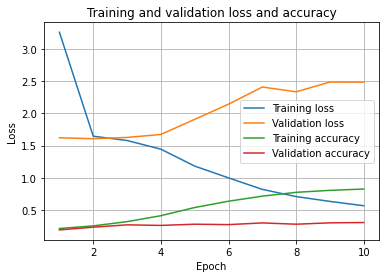

In [5]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

As we see above we only reach about 0.30
(30%) accuracy. Maybe this is due to images belonging to more than one class (i.e. a cover may belong to both electronic and hiphop). Also we should reduce complexity, because it has ~10.3 million parameters to train.

## 2.1 Reduce Complexity

In the MNIST example we can see, that we can reach a better accuracy with less complexity. Therefore we will change the activation function of our last layer to sigmoid instead of softmax. Also we are using binary crossentropy as a loss fucntion. The complexity is reduced by changing the 64 Conv2D to 32 and using convolutional filters of `3x3` instead of `5x5`

In [4]:
# describe model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
# history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, y_test)) # das hier dürfte falsch sein, da validation und test data nicht die selben sein sollten
history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4718656   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

Epoch 50/50
32/32 [==============================] - 0s 14ms/step - loss: 1.3815 - accuracy: 0.2750
Test score: 1.3814646005630493
Test accuracy: 0.2750000059604645


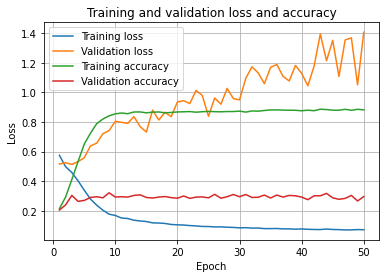

In [5]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

As we can see reducing the complexity has a minimal effect to our accuracy. We lost 3% accuracy, but reduced the params from $10*10^{6}$ to $4*10^{6}$

## 2.2 Introducing Dropout

The next is to introduce dropout, that will help us to avoid overfitting. But as you can see in the result, our accuracy is dropped to $0.238$.

In [6]:

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 32)      2432      
_________________________________________________________________
dropout (Dropout)            (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 64)      51264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 64)       

Epoch 100/100
32/32 [==============================] - 1s 21ms/step - loss: 0.5113 - accuracy: 0.2380
Test score: 0.5113413333892822
Test accuracy: 0.23800000548362732


## 2.3 Using data augmentation
The next step is to use data augmentation. We hope that if we train with a larger set of data, we can improve our accuracy.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

BATCH_SIZE = 20
IMG_SIZE = 200
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_directory(
    './data/covers/training',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

validation_gen = validation_datagen.flow_from_directory(
    './data/covers/validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_directory(
    './data/covers/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=10
)

# compute loss and accuracy on test data
score = model.evaluate(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 4000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 160000)            0        

# 3.0 Pre-trained neural networks 

All our approaches did not get better results than the MNIST model with an accuracy of $0.312$. It seems that we have to look into pre-trained neural networks. Our first network is VGG16. VGG16 is a convolutional neutal network model. VGG16 was invented by K. Simonyan and A. Zisserman. They achieved an accuracy of $92.2%$ in ImageNet. ImageNet uses 14 million images belonging to 1000 classes. This network is trained on a large set and performed well. We will see how it performs with our task of classifying album covers.

<cite>https://neurohive.io/en/popular-networks/vgg16/</cite>

![alt text](./img/vgg16-neural-network.jpg)



In [20]:

df = pd.read_csv('./data/df_neu.csv', index_col=0)
df['categories']=df['categories'].apply(lambda x:x.split(","))

df = shuffle(df)
df_train, df_test, df_validate = np.split(df, [int(len(df)*PERC_TRAIN), int(len(df)*(1.0-PERC_VALIDATE))])

BATCH_SIZE = 20
IMG_SIZE = 200
CLASSES = ['electronic', 'hiphop', 'jazz', 'pop', 'rock']
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_dataframe(
    df_train,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
#     class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CLASSES,
    batch_size=BATCH_SIZE,
)

validation_gen = validation_datagen.flow_from_dataframe(
    df_validate,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
#     class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=CLASSES,
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    directory='./data/covers_original',
    x_col='src',
    y_col='categories',
    target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode=None,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
)


# download VGG16 model for image classification
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

# define the architecture of the neural network building on VGG15
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=10
)

# compute loss and accuracy on test data
score = model.evaluate(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

/home/kkuntz/.local/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3276 invalid image filename(s) in x_col="src". These filename(s) will be ignored.
  warnings.warn(
/home/kkuntz/.local/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 410 invalid image filename(s) in x_col="src". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 5 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 19,433,793
Trainable params: 4,719,105
Non-trainable params: 14,714,688
_________________________________________________________________


ValueError: Asked to retrieve element 0, but the Sequence has length 0